# Preprocessing: Baseline ARIMA model for Cardano(ADA) 

## Overview: 

Up to this point, we have seen that Cardano has had a volatile 4-years since it's inception. It has increased in value exponentially within the first few months of it being listed on exchanges to purchase and trade. It has grown from being worth less than half a billion dollars to over forty billion dollars in marketcap in just four years. 

As outlined in the EDA notebook, Cardano's success is largely contingent upon the direction Bitcoin is moving in the market. If Bitcoin is on a downward trajectory, Cardano will follow; the same can be said for movement to the upside. Even though the usecase for each cryptocurrency is so different, with Bitcoin being primarily the 'gold' of digital currency and Cardano creating and attempting to roll out their blockchain to trade, purchase and sell digital goods, Bitcoin's movement determines the value of Cardano for those attempting to make profit off of trading. 

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Test for data stationarity with KPSS
- Make the ARIMA Model
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps

# 1. Sourcing and Loading 

In [34]:
# import and load libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [35]:
# load df and print first 10 rows
ADA_df = pd.read_csv('../Capstone_Project_3/Data/ADA_df.csv')
ADA_df.head()

,Unnamed: 0,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,0,ADA,2017-10-02,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,1,ADA,2017-10-03,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,2,ADA,2017-10-04,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,3,ADA,2017-10-05,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,4,ADA,2017-10-06,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [36]:
#check dtypes
ADA_df.dtypes

Unnamed: 0      int64
Symbol         object
Date           object
High          float64
Low           float64
Open          float64
Close         float64
Volume        float64
Marketcap     float64
dtype: object

# 2. Cleaning, Transforming, Visualizing

In [37]:
#create df with only 'Date' and 'Close'
df = ADA_df[['Date', 'Close']]
df.head()

,Date,Close
0,2017-10-02,0.025932
1,2017-10-03,0.020816
2,2017-10-04,0.021931
3,2017-10-05,0.021489
4,2017-10-06,0.018539


In [38]:
#change 'Date' to 'Day' since the granularity is 24 hours. 
df = df.rename(columns={'Date':'Day', 'Close':'Price'})
df.tail()

,Day,Price
1240,2021-02-23,0.954709
1241,2021-02-24,1.051657
1242,2021-02-25,1.079116
1243,2021-02-26,1.241105
1244,2021-02-27,1.324860


In [39]:
#convert 'Day' from an object to a datetime64. 
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace = True)

In [40]:
#make 'Price' the predictor variable 'y' and check data type
y = df['Price']
y.dtypes

dtype('float64')

In [41]:
#get summary statistics of 'y'
y.describe()

count    1245.000000
mean        0.138757
std         0.177812
min         0.018539
25%         0.044328
50%         0.080952
75%         0.143573
max         1.324860
Name: Price, dtype: float64

<AxesSubplot:xlabel='Day'>

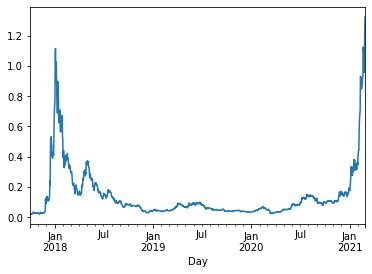

In [42]:
# plot 'y'
y.plot()

# Decomposition 

**Trend**: ADA does have an upward trend from when it began to this point. It looks as though once a peak has formed you can expect extreme downward motion. 
**Seasonality**: It does not look like there is seasonality that can be intuited from this representation. 
**Noise**: There is quite a bit of variance in the price. 

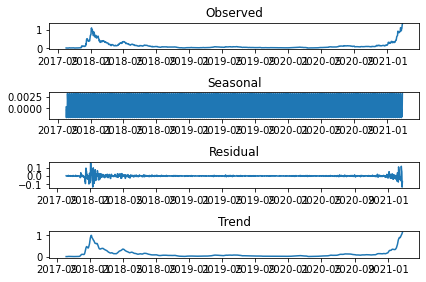

In [43]:
#plot the seasonality, trend, and residuals compared to the observed line
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
observed = decomposition.observed
seasonal = decomposition.seasonal
residual = decomposition.resid
trend = decomposition.trend

plt.subplot(411)
plt.title('Observed')
plt.plot(observed, label='Observed')
plt.subplot(412)
plt.title('Seasonal')
plt.plot(seasonal, label='Seasonal')
plt.subplot(413)
plt.title('Residual')
plt.plot(residual, label='Residual')
plt.subplot(414)
plt.title('Trend')
plt.plot(trend, label='Trend')
plt.tight_layout(pad=1)

In [44]:
#check for stationarity
from statsmodels.tsa.stattools import kpss
kpss(y)

(0.5568613792080169,
 0.02886004972792411,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

With the p-value being less than .05, we can reject the null hypothesis and assume that our data is not stationary. 

<AxesSubplot:xlabel='Day'>

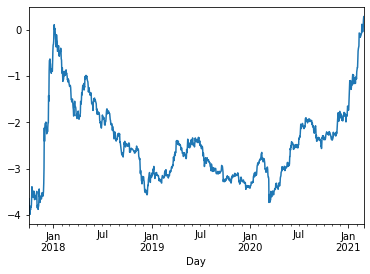

In [46]:
y_log = np.log(y)
y_log.plot()

In [83]:
y_adj = y_log.diff().dropna()

In [52]:
#with the variance addressed, we must address the lack of a constant mean. 
#.diff() function on y_log should do the trick. 
import warnings
warnings.filterwarnings("ignore")
kpss(y_log.diff().dropna())

(0.21929158236343513,
 0.1,
 23,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The p-value is now above .05, indicating the constant mean and constant variance has been effected in a way that can allow us to accept the null hypothesis that the stationarity of the data is acceptable. 

In [55]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [56]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [57]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [58]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [59]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.924
ARIMA(0, 0, 1) MSE=0.258
ARIMA(0, 1, 0) MSE=0.004
ARIMA(0, 1, 1) MSE=0.004
ARIMA(0, 1, 2) MSE=0.004
ARIMA(0, 2, 0) MSE=0.008
ARIMA(0, 2, 1) MSE=0.004
ARIMA(0, 2, 2) MSE=0.004
ARIMA(1, 0, 0) MSE=0.004
ARIMA(1, 0, 1) MSE=0.004
ARIMA(1, 0, 2) MSE=0.004
ARIMA(1, 1, 0) MSE=0.004
ARIMA(1, 1, 1) MSE=0.004
ARIMA(1, 1, 2) MSE=0.004
ARIMA(1, 2, 0) MSE=0.006
ARIMA(1, 2, 1) MSE=0.004
ARIMA(1, 2, 2) MSE=0.004
ARIMA(2, 0, 0) MSE=0.004
ARIMA(2, 0, 1) MSE=0.004
ARIMA(2, 0, 2) MSE=0.004
ARIMA(2, 1, 0) MSE=0.004
ARIMA(2, 1, 1) MSE=0.004
ARIMA(2, 1, 2) MSE=0.004
ARIMA(2, 2, 0) MSE=0.006
ARIMA(2, 2, 1) MSE=0.004
ARIMA(2, 2, 2) MSE=0.004
Best ARIMA(0, 2, 1) MSE=0.004


In [60]:
#build model with parameters set to Best ARIMA findings above
p=0
d=2
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(30)

In [61]:
#summary of model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Price   No. Observations:                 1243
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1460.267
Method:                       css-mle   S.D. of innovations              0.075
Date:                Wed, 23 Jun 2021   AIC                          -2914.534
Time:                        17:43:21   BIC                          -2899.158
Sample:                    10-04-2017   HQIC                         -2908.752
                         - 02-27-2021                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.037e-05    4.8e-05      0.216      0.829   -8.38e-05       0.000
ma.L1.D2.Price    -0.9784      0.011    -88.249      0.000      -1.000      -0.957
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0221           +0.0000j            1.0221            0.0000
-----------------------------------------------------------------------------
"""

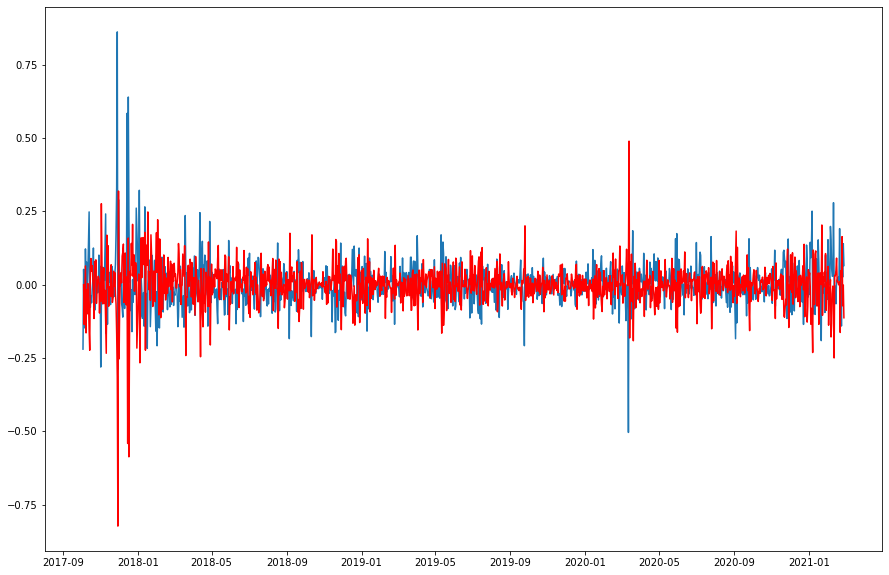

In [62]:
#visualize results
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color='red')

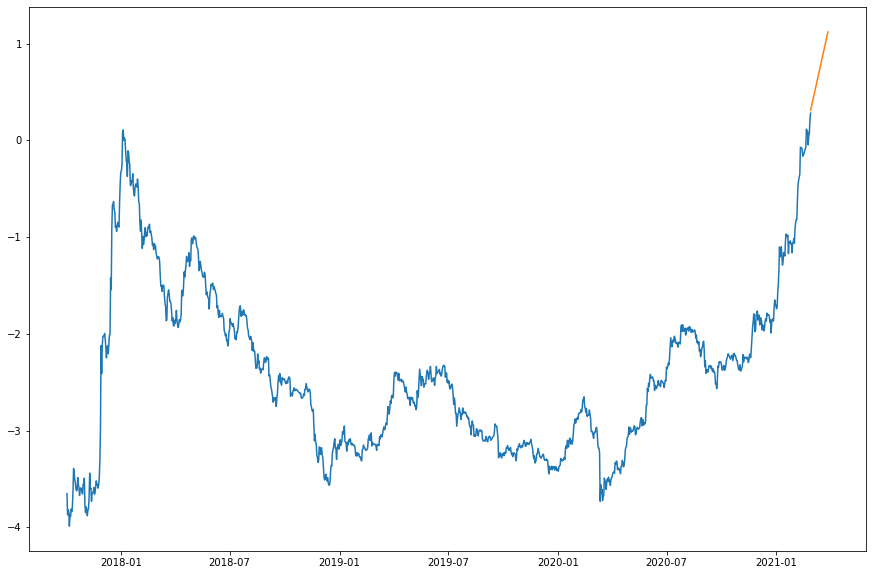

In [80]:
#forecasting 
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 30
date_range = pd.date_range(y_log.index[-1], periods=forecast_period, freq='D').strftime('%Y-%m-%d').tolist()
# Convert that range into a dataframe that includes your predictions
future_days = pd.DataFrame(date_range, columns=['Day'])
future_days['Day'] = pd.to_datetime(future_days['Day'])
future_days.set_index('Day', inplace = True)
future_days['Prediction'] = forecast[0]

# Plot your future predictions
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(future_days['Prediction'])
plt.show()

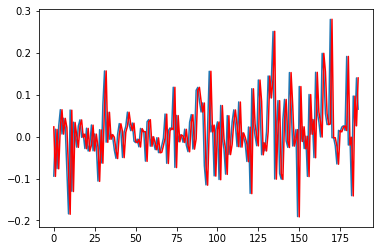

In [120]:
# split into train and test sets
X = y_adj.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,2,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
#	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
#print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [144]:
forecast = np.array(predictions)
forecast.shape

(187, 1)

In [147]:
test1 = np.vstack(test)
test1.shape

(187, 1)

In [150]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
             'minmax':minmax})
forecast_accuracy(forecast, test1)

{'mape': 5.325058313648767,
 'me': -0.0005790951570171786,
 'mae': 0.07252355346981523,
 'mpe': -0.4017095341936765,
 'rmse': 0.09831547046143059,
 'minmax': -0.13006396607078496}